# CNN实现手写数字识别

## Package

In [3]:
import sys ,os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf #只是用来加载mnist数据集
from PIL import Image
import pandas as pd 
import math

## 加载MNIST数据集

In [4]:
def one_hot_label(y):
    one_hot_label = np.zeros((y.shape[0],10))
    y = y.reshape(y.shape[0])
    one_hot_label[range(y.shape[0]),y] = 1
    return one_hot_label
    
    

In [6]:
# #（训练图像，训练标签），（测试图像，测试标签）
# # mnist的图像均为28*28尺寸的数据，通道为1
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()
X_train = x_train_origin/255.0
X_test = x_test_origin/255.0
m,h,w = x_train_origin.shape
X_train = X_train.reshape((m,1,h,w))
y_train = one_hot_label(t_train_origin)

m,h,w = x_test_origin.shape
X_test = X_test.reshape((m,1,h,w))
y_test = one_hot_label(t_test_origin)
print("shape of x_train is :"+repr(X_train.shape))
print("shape of t_train is :"+repr(y_train.shape))
print("shape of x_test is :"+repr(X_test.shape))
print("shape of t_test is :"+repr(y_test.shape))


shape of x_train is :(60000, 1, 28, 28)
shape of t_train is :(60000, 10)
shape of x_test is :(10000, 1, 28, 28)
shape of t_test is :(10000, 10)


## 显示图像

y is:5


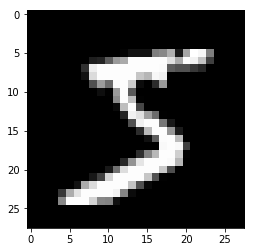

In [7]:
index = 0
plt.imshow(X_train[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is:"+str(np.argmax(y_train[index])))

## 辅助函数

将根据滤波器的大小，步幅，填充，输入数据展开为2维数组。

In [8]:
def im2col2(input_data,fh,fw,stride=1,pad=0):
    '''
     Arguments:
     
     input_data--输入数据，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     col -- 输入数据根据滤波器、步幅等展开的二维数组，每一行代表一条卷积数据
    '''
    N,C,H,W = input_data.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1
    
    img = np.pad(input_data,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")
    
    col = np.zeros((N,out_h,out_w,fh*fw*C))
    
    #将所有维度上需要卷积的值展开成一列
    for y in range(out_h):
        y_start = y * stride
        y_end =  y_start + fh
        for x in range(out_w):
            x_start = x*stride
            x_end = x_start+fw
            col[:,y,x] = img[:,:,y_start:y_end,x_start:x_end].reshape(N,-1)
    col = col.reshape(N*out_h*out_w,-1)
    return col

    

将二维数据转成image

In [11]:
def col2im2(col,out_shape,fh,fw,stride=1,pad=0):
    '''
     Arguments:
     col: 二维数组     
     out_shape-- 输出的shape，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     img -- 将col转换成的img ，shape为out_shape
    '''
    N,C,H,W = out_shape
    
    col_m,col_n = col.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1

    

    img = np.zeros((N, C, H , W))
   # img = np.pad(img,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")

    #将col转换成一个filter
    for c in range(C):
        for y in range(out_h):
            for x in range(out_w):
                col_index = (c*out_h*out_w)+y*out_w+x
                ih = y*stride
                iw =  x*stride
                img[:,c,ih:ih+fh,iw:iw+fw] = col[col_index].reshape((fh,fw))
    return img


In [12]:
def im2col2test():
    a = np.random.randint(0,5,size=(2,3,4,4))
    c = im2col2(a,2,2,2,1)

    a = np.random.randint(0,5,size=(1,1,3,3))
    print(a)
    c = im2col2(a,2,2,1,0)
    print(c)
    col2im2(c,out_shape=(1,1,3,3),fh=2,fw=2,stride=1)

### 激活函数

In [13]:
def relu(input_X):
    """
    Arguments:
        input_X -- a numpy array
    Return :
        A: a numpy array. let each elements in array all greater or equal 0
    """
    
    A = np.where(input_X < 0 ,0,input_X)
    return A
    

In [14]:
def softmax(input_X):
    """
    Arguments:
        input_X -- a numpy array
    Return :
        A: a numpy array same shape with input_X
    """
    exp_a = np.exp(input_X)
    sum_exp_a = np.sum(exp_a,axis=1)
    sum_exp_a = sum_exp_a.reshape(input_X.shape[0],-1)
    ret = exp_a/sum_exp_a
   # print(ret)
    return ret

### 损失函数

In [15]:
def cross_entropy_error(labels,logits):
    return -np.sum(labels*np.log(logits))


## 卷积层

In [17]:
class Convolution:
    def __init__(self,W,fb,stride = 1,pad = 0):
        """
        W-- 滤波器权重，shape为(FN,NC,FH,FW),FN 为滤波器的个数
        fb -- 滤波器的偏置，shape 为(1,FN) 
        stride -- 步长
        pad -- 填充个数
        """
        self.W = W
        self.fb  = fb  
        self.stride = stride
        self.pad = pad
        
        
        self.col_X = None
        self.X = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        self.out_shape = None
    #    self.out = None
        
    def forward (self ,input_X):
        """
        input_X-- shape为(m,nc,height,width)
        """   
        self.X = input_X
        FN,NC,FH,FW = self.W.shape
        
        m,input_nc, input_h,input_w = self.X.shape
    
        #先计算输出的height和widt
        out_h = int((input_h+2*self.pad-FH)/self.stride + 1)
        out_w = int((input_w+2*self.pad-FW)/self.stride + 1)
    
        #将输入数据展开成二维数组，shape为（m*out_h*out_w,FH*FW*C)
        self.col_X = col_X = im2col2(self.X,FH,FW,self.stride,self.pad)
        
        #将滤波器一个个按列展开(FH*FW*C,FN)
        self.col_W = col_W = self.W.reshape(FN,-1).T
        out = np.dot(col_X,col_W)+self.fb
        out = out.T
        out = out.reshape(m,FN,out_h,out_w)
        self.out_shape = out.shape
        return out
    
    def backward(self, dz,learning_rate):
        #print("==== Conv backbward ==== ")
        assert(dz.shape == self.out_shape)
    
        FN,NC,FH,FW = self.W.shape
        o_FN,o_NC,o_FH,o_FW = self.out_shape
        
        col_dz  = dz.reshape(o_NC,-1)
        col_dz = col_dz.T
        
        self.dW = np.dot(self.col_X.T,col_dz)  #shape is (FH*FW*C,FN)
        self.db = np.sum(col_dz,axis=0,keepdims=True)

        
        self.dW = self.dW.T.reshape(self.W.shape)
        self.db = self.db.reshape(self.fb.shape)
        
    
        d_col_x = np.dot(col_dz,self.col_W.T) #shape is (m*out_h*out_w,FH,FW*C)
        dx = col2im2(d_col_x,self.X.shape,FH,FW,stride=1)
        
        assert(dx.shape == self.X.shape)
        
        #更新W和b
        self.W = self.W - learning_rate*self.dW
        self.fb = self.fb -learning_rate*self.db
        
        return dx
    
    

## 池化层

In [18]:
class Pooling:
    def __init__(self,pool_h,pool_w,stride = 1,pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad 
        self.X = None
        self.arg_max = None
        
    def forward ( self,input_X) :
        """
        前向传播
        input_X-- shape为(m,nc,height,width)
        """  
        self.X = input_X
        N , C, H, W = input_X.shape
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)
        
        #展开
        col = im2col2(input_X,self.pool_h,self.pool_w,self.stride,self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)
        arg_max = np.argmax(col,axis=1)
        #最大值
        out = np.max(col,axis=1)
        out =out.T.reshape(N,C,out_h,out_w)
        self.arg_max = arg_max
        return out
    
    def backward(self ,dz):
        """
        反向传播
        Arguments:
        dz-- out的导数，shape与out 一致
        
        Return:
        返回前向传播是的input_X的导数
        """ 
        pool_size = self.pool_h*self.pool_w
        dmax = np.zeros((dz.size,pool_size))
        dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dz.flatten()
        
        dx = col2im2(dmax,out_shape=self.X.shape,fh=self.pool_h,fw=self.pool_w,stride=self.stride)
        return dx
    
    

## Relu层

In [19]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self ,X):
        self.mask = X <= 0
        out = X
        out[self.mask] = 0
        return out
    
    def backward(self,dz):
        dz[self.mask] = 0
        dx = dz 
        return dx

## SoftMax层

In [20]:
class SoftMax:
    def __init__ (self):
        self.y_hat = None
        
    def forward(self,X):
        
        self.y_hat = softmax(X)
        return self.y_hat
    
    def backward(self,labels):
        m = labels.shape[0]
        dx = (self.y_hat - labels)
        
        return dx
    

In [21]:
def compute_cost(logits,label):
    return cross_entropy_error(label,logits)

## Affine FC层

In [22]:
class Affine:
    def __init__(self,W,b):
        self.W = W # shape is (n_x,n_unit)
        self.b  = b  # shape is(1,n_unit)
        self.X = None
        self.origin_x_shape = None
        
        self.dW = None
        self.db = None
        
        self.out_shape =None
        
    def forward(self,X):
        self.origin_x_shape = X.shape 
        self.X = X.reshape(X.shape[0],-1)#(m,n)
        out =  np.dot(self.X, self.W)+self.b
        self.out_shape = out.shape
        return out
    
    def backward(self,dz,learning_rate):
        """
        dz-- 前面的导数
        """  
#         print("Affine backward")
#         print(self.X.shape)
#         print(dz.shape)
#         print(self.W.shape)
    
        assert(dz.shape == self.out_shape)
        
        m = self.X.shape[0]
        
        self.dW = np.dot(self.X.T,dz)/m
        self.db = np.sum(dz,axis=0,keepdims=True)/m
        
        assert(self.dW.shape == self.W.shape)
        assert(self.db.shape == self.b.shape)
        
        dx = np.dot(dz,self.W.T)
        assert(dx.shape == self.X.shape)
        
        dx = dx.reshape(self.origin_x_shape) # 保持与之前的x一样的shape
        
        #更新W和b
        self.W = self.W-learning_rate*self.dW
        self.b = self.b - learning_rate*self.db
        
        return dx
        

## 模型


In [97]:
class SimpleConvNet:

    def __init__(self):
        self.X = None
        self.Y= None
        self.layers = []

    def add_conv_layer(self,n_filter,n_c , f, stride=1, pad=0):
        """
        添加一层卷积层
        Arguments:
        n_c -- 输入数据通道数，也即卷积层的通道数
        n_filter -- 滤波器的个数
        f --滤波器的长/宽

        Return :
        Conv -- 卷积层
        """

        # 初始化W，b
        W = np.random.randn(n_filter, n_c, f, f)*0.01
        fb = np.zeros((1, n_filter))
        # 卷积层
        Conv = Convolution(W, fb, stride=stride, pad=pad)
        return Conv

    def add_maxpool_layer(self, pool_shape, stride=1, pad=0):
        """
        添加一层池化层
        Arguments:
        pool_shape -- 滤波器的shape
        f -- 滤波器大小
        Return :
         Pool -- 初始化的Pool类
        """
        pool_h, pool_w = pool_shape
        pool = Pooling(pool_h, pool_w, stride=stride, pad=pad)
        
        return pool
    
    def add_affine(self,n_x, n_units):
        """
        添加一层全连接层
        Arguments:
        n_x -- 输入个数
        n_units -- 神经元个数
        Return :
        fc_layer -- Affine层对象
        """
        
        W= np.random.randn(n_x, n_units)*0.01
        
        b = np.zeros((1, n_units))
        
        fc_layer = Affine(W,b)
        
        return fc_layer
    
    def add_relu(self):
        relu_layer =  Relu()
        return relu_layer
    
    
    def add_softmax(self):
        softmax_layer = SoftMax()
        return softmax_layer
    
    #计算卷积或池化后的H和W
    def cacl_out_hw(self,HW,f,stride = 1,pad = 0):
        return (HW+2*pad - f)/stride+1
    

    
    
    def init_model(self,train_X,n_classes):
        """
        初始化一个卷积层网络
        """
        N,C,H,W = train_X.shape
        #卷积层
        n_filter = 4
        f = 7
        
        conv_layer = self.add_conv_layer(n_filter= n_filter,n_c=C,f=f,stride=1)
        
        out_h = self.cacl_out_hw(H,f)
        out_w = self.cacl_out_hw(W,f)
        out_ch = n_filter
        
        self.layers.append(conv_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #池化
        f = 2
        pool_layer = self.add_maxpool_layer(pool_shape=(f,f),stride=2)
        out_h = self.cacl_out_hw(out_h,f,stride=2)
        out_w = self.cacl_out_hw(out_w,f,stride=2)
        #out_ch 不改变
        self.layers.append(pool_layer)
        

        
        
        #Affine层
        n_x = int(out_h*out_w*out_ch)
        n_units = 32
        fc_layer = self.add_affine(n_x=n_x,n_units=n_units)
        self.layers.append(fc_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #Affine
        fc_layer = self.add_affine(n_x=n_units,n_units=n_classes)
        self.layers.append(fc_layer)
        
        #SoftMax
        softmax_layer = self.add_softmax()
        self.layers.append(softmax_layer)
        
        
        
    def forward_progation(self,train_X, print_out = False):
        """
        前向传播
        Arguments:
        train_X -- 训练数据
        f -- 滤波器大小

        Return :
         Z-- 前向传播的结果
         loss -- 损失值
        """
    
        
        N,C,H,W = train_X.shape
        index = 0
        # 卷积层
        conv_layer = self.layers[index]
        X = conv_layer.forward(train_X)
        index =index+1
        if print_out:
            print("卷积之后："+str(X.shape))
        # Relu
        relu_layer =  self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu："+str(X.shape))
            
        
        # 池化层
        pool_layer = self.layers[index]
        index =index+1
        X = pool_layer.forward(X)
        if print_out:
            print("池化："+str(X.shape))


        #Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        #Relu
        relu_layer = self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu 层的X："+str(X.shape))
        
        #Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        #SoftMax层
        sofmax_layer = self.layers[index]
        index =index+1
        A = sofmax_layer.forward(X)
        if print_out:
            print("Softmax 层的X："+str(A.shape))
            
        return A
        
    def back_progation(self,train_y,learning_rate):
        """
        反向传播
        Arguments:
   
        """
        index = len(self.layers)-1
        sofmax_layer = self.layers[index]
        index -= 1
        dz = sofmax_layer.backward(train_y)
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        relu_layer = self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        pool_layer = self.layers[index]
        dz = pool_layer.backward(dz)
        index -= 1
        
        relu_layer =  self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        conv_layer = self.layers[index]
        conv_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
      
    def get_minibatch(self,batch_data,minibatch_size,num):
        m_examples = batch_data.shape[0]
        minibatches = math.ceil( m_examples / minibatch_size)
 
        if(num < minibatches):
            return batch_data[num*minibatch_size:(num+1)*minibatch_size]
        else:
            return batch_data[num*minibatch_size:m_examples]
    
    
    def optimize(self,train_X, train_y,minibatch_size,learning_rate=0.05,num_iters=500):
        """
        优化方法
        Arguments:
        train_X -- 训练数据 
        train_y -- 训练数据的标签
        learning_rate -- 学习率
        num_iters -- 迭代次数
        minibatch_size 
        """
        m = train_X.shape[0]
        num_batches  = math.ceil(m / minibatch_size)
        
        costs = []
        for iteration in range(num_iters):
            iter_cost = 0
            for batch_num in range(num_batches):
                minibatch_X = self.get_minibatch(train_X,minibatch_size,batch_num)
                minibatch_y = self.get_minibatch(train_y,minibatch_size,batch_num)
                
                # 前向传播
                A = self.forward_progation(minibatch_X,print_out=False)
                #损失:
                cost = compute_cost (A,minibatch_y)
                #反向传播
                self.back_progation(minibatch_y,learning_rate)
                if(iteration%100 == 0):
                    iter_cost += cost/num_batches
                    
            if(iteration%100 == 0):
                print("After %d iters ,cost is :%g" %(iteration,iter_cost))
                costs.append(iter_cost)
            
            
            
            
        #画出损失函数图
        plt.plot(costs)
        plt.xlabel("iterations/hundreds")
        plt.ylabel("costs")
        plt.show()
        
       
    def predicate(self, train_X):
        """
        预测
        """
        logits = self.forward_progation(train_X)
        one_hot = np.zeros_like(logits)
        one_hot[range(train_X.shape[0]),np.argmax(logits,axis=1)] = 1
        return one_hot   

    def fit(self,train_X, train_y):
        """
        训练
        """
        self.X = train_X
        self.Y = train_y
        n_y = train_y.shape[1]
        m = train_X.shape[0]
        
        #初始化模型
        self.init_model(train_X,n_classes=n_y)

        self.optimize(train_X, train_y,minibatch_size=10,learning_rate=0.05,num_iters=800)
        
        logits = self.predicate(train_X)
        
        accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(train_y,axis=1))/m
        print("训练集的准确率为：%g" %(accuracy))

After 0 iters ,cost is :23.0254
After 100 iters ,cost is :14.5255
After 200 iters ,cost is :6.01782
After 300 iters ,cost is :5.71148
After 400 iters ,cost is :5.63212
After 500 iters ,cost is :5.45006
After 600 iters ,cost is :5.05849
After 700 iters ,cost is :4.29723


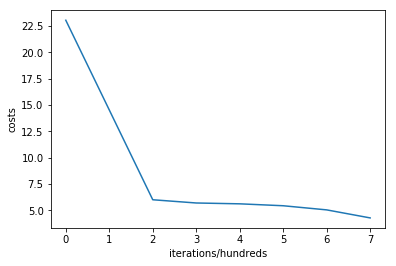

训练集的准确率为：0.9


In [98]:
convNet = SimpleConvNet()
#拿20张先做实验
train_X = X_train[0:10]
train_y = y_train[0:10]
convNet.fit(train_X,train_y)

## 预测

In [120]:
logits = convNet.predicate(X_train[0:10])
m = 10
accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(y_train[0:10],axis=1))/m
print("训练的准确率为：%g" %(accuracy))

训练的准确率为：0.9


y is:5
your predicate result is :5


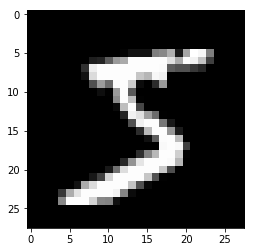

In [121]:
index = 0
plt.imshow(X_train[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is:"+str(np.argmax(y_train[index])))
print("your predicate result is :"+str(np.argmax(logits[index])))

In [99]:
logits = convNet.predicate(X_test)
m = X_test.shape[0]
accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(y_test,axis=1))/m
print("测试的准确率为：%g" %(accuracy))

测试的准确率为：0.1031
